In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf

from glob import glob
from re import findall,sub
from tqdm.notebook import tqdm

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import  *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

%matplotlib inline

/home/codekage/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/codekage/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/codekage/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/codekage/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
tf.config.experimental_list_devices()

['/job:localhost/replica:0/task:0/device:CPU:0',
 '/job:localhost/replica:0/task:0/device:XLA_GPU:0',
 '/job:localhost/replica:0/task:0/device:XLA_CPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
images = glob("./lfw_funneled/*/*")

In [4]:
people = np.array([[" ".join(i.split("/")[-1].split("_")[:-1]),i] for i in images])

In [5]:
imgs = np.array([cv2.imread(i[1]) for i in tqdm(people)])

In [6]:
imgs.shape

(13233, 250, 250, 3)

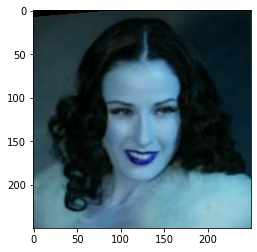

In [7]:
plt.imshow(imgs[0])

In [8]:
haar = cv2.CascadeClassifier()

In [9]:
haar.load("../haarcascade_frontalface_default.xml")

True

In [14]:
faces_name = []
faces_mask = []

error = []

for p,f in tqdm(zip(people[:,0],imgs),total=imgs.shape[0]):
    try:
        x,y,w,h = haar.detectMultiScale(f)[0]
        roi = cv2.resize(f[y:y+h,x:x+w],(128,128))
        faces_name.append(p)
        faces_mask.append(roi)
    except:
        error.append([p,f])

In [15]:
faces_name = np.array(faces_name)
np.save("./fn.npy",faces_name,)

In [16]:
faces_mask = np.array(faces_mask)

In [17]:
np.save("./face_128.npy",faces_mask,)

In [3]:
faces_mask = np.load("./face_128.npy")

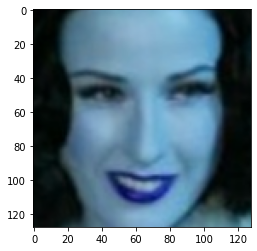

In [4]:
plt.imshow(faces_mask[0])

In [5]:
faces_mask.shape

(13197, 128, 128, 3)

In [6]:
labels = np.random.randint(0,1024,(faces_mask.shape[0],128))
train = faces_mask.copy()

In [7]:
def _gen(x,y,bs=10,epochs=1):
    for i in range(epochs):
        right = x.shape[0] % bs
        
        left_x = x[:-right].reshape(-1,bs,64,64,3)
        right_x = x[-right:]
        
        left_y = y[:-right].reshape(-1,bs,128)
        right_y = y[-right:]
        
        for _x,_y in zip(left_x,left_y):
            yield _x,_y 
        yield right_x,right_y

In [8]:
inputs = Input(shape=(128,128,3))

conv1 = Conv2D(16,4,activation="relu",input_shape=(128,128,3))(inputs)
conv2 = Conv2D(16,2,activation="relu",)(conv1)
pool1 = MaxPool2D()(conv2)
conv3 = Conv2D(32,3,activation="relu",)(pool1)
conv4 = Conv2D(32,3,activation="relu",)(conv3)
pool2 = MaxPool2D()(conv4)

flat = Flatten()(pool2)
out = Dense(128)(flat)

embedding = Model(inputs,out)
embedding.compile(optimizer="adam",loss="mae")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
embedding.compile(optimizer="rmsprop",loss="mae")

In [10]:
embedding.fit(faces_mask,labels,batch_size=16,epochs=10)

Epoch 1/10
13197/13197 [==============================] - 14s 1ms/sample - loss: 269.7355
Epoch 2/10
13197/13197 [==============================] - 13s 951us/sample - loss: 262.8408
Epoch 3/10
13197/13197 [==============================] - 13s 951us/sample - loss: 256.5287
Epoch 4/10
13197/13197 [==============================] - 13s 953us/sample - loss: 247.0079
Epoch 5/10
13197/13197 [==============================] - 13s 956us/sample - loss: 235.1098
Epoch 6/10
13197/13197 [==============================] - 13s 957us/sample - loss: 222.5468
Epoch 7/10
13197/13197 [==============================] - 13s 966us/sample - loss: 210.7760
Epoch 8/10
13197/13197 [==============================] - 13s 966us/sample - loss: 199.6977
Epoch 9/10
13197/13197 [==============================] - 13s 966us/sample - loss: 190.1437
Epoch 10/10
13197/13197 [==============================] - 15s 1ms/sample - loss: 181.4962


In [11]:
embedding.save_weights("./128_by_128_emb.h5")